In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from scipy.integrate import trapz
from matplotlib import pyplot as plt
import abstractions as abs

plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1

EdgeDataView([('R', 'R', {'weight': 3, 'wall_kwargs': {'Tf0': 293.15}, 'wall': <abstractions.WallSimulation object at 0x17b2edae0>, 'T_profs': array([[293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       ...,
       [293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]])})])

NodeDataView({'R': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}, 'room': <abstractions.RoomSimulation object at 0x17b29b640>, 'vent': <abstractions.VentilationSimulation object at 0x17b2edb70>, 'Tints': array([293.15,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]), 'Vnvs': array([0., 0., 0., ..., 0., 0., 0.]), 'Ef': 0}})

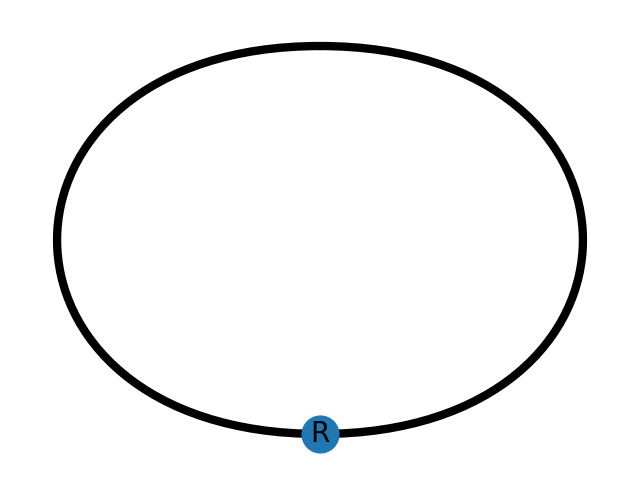

In [64]:
sim_kwargs = {
    "delt": 15,
    "simLength": 96 * 60 * 60,
    "Tout" : None
}
wall_kwargs = {
    "Tf0" : 293.15
}
room_kwargs = {
    "T0": 293.15
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP1",
    "alphas": None,
    "As": None,
    "Ls": None
}

roomList = [
    ("R", {}), # room
    ]

connectivityMatrix = np.array([
    [3],
])

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

bG.updateAllEdges({"wall_kwargs" :wall_kwargs})
bG.updateAllNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs
    })


build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)

# show graph edge data
display(build_sim.bG.G.edges.data())
display(build_sim.bG.G.nodes.data())

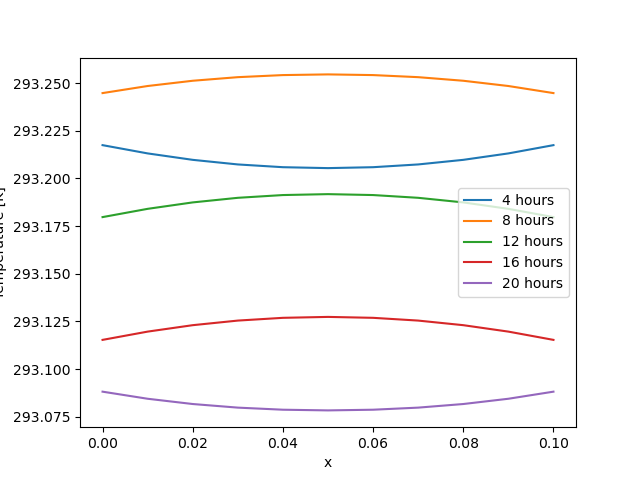

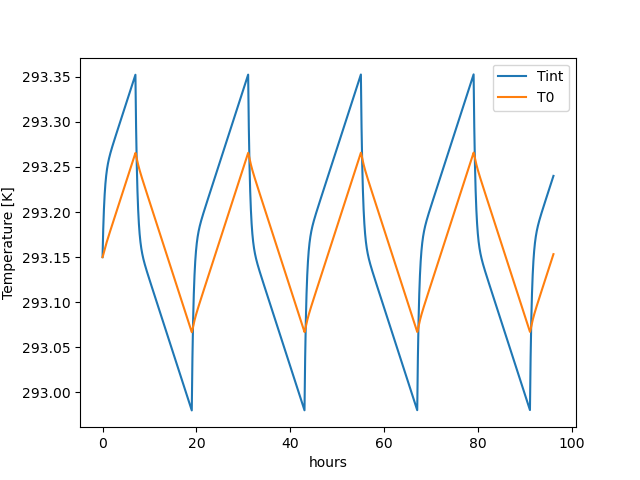

In [65]:
build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']

# Tints, T_profs, _ = build_sim.runOld()

# h_profs = np.arange(4, 24, 4)
# h_profs += 48

# Plotting
plt.figure()
plt.plot(build_sim.hours, Tints, label='Tint')
plt.plot(build_sim.hours, T_profs[0, :], label='T0')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

plt.figure()
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

## Problem 4

In [66]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
Tints[0] = T_start
Touts = Q4['Tout'].flatten() + 273.15

Text(0, 0.5, 'Temperature [K]')

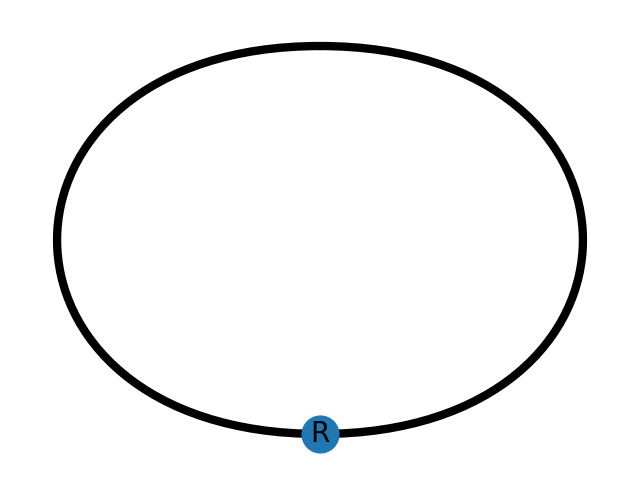

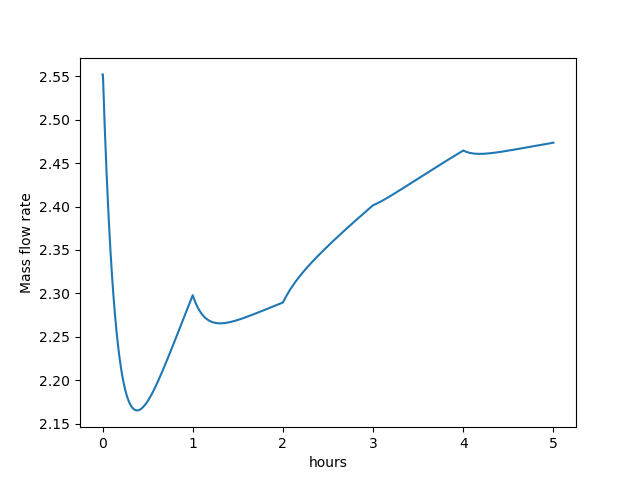

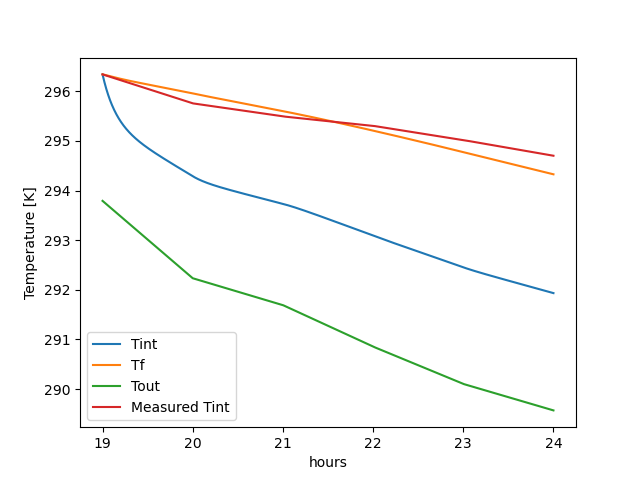

In [74]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts
}
wall_kwargs = {
    "Tf0" : T_start
}
room_kwargs = {
    "T0": T_start
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": "HWP4",
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

bG.updateAllEdges({"wall_kwargs" :wall_kwargs})
bG.updateAllNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs
    })

build_sim = abs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

Tints = build_sim.bG.G.nodes['R']['Tints']
T_profs = build_sim.bG.G.edges['R', 'R']['T_profs']
wall = build_sim.bG.G.edges['R', 'R']['wall']
Vnvs = build_sim.bG.G.nodes['R']['Vnvs']
Vnvs[0] = Vnvs[1]

# Plotting
plt.figure()
plt.plot(build_sim.hours, Vnvs)
plt.xlabel('hours')
plt.ylabel('Mass flow rate')

plt.figure()
plt.plot(hours, Tints, label='Tint')
plt.plot(hours, T_profs[0, :], label='Tf')
plt.plot(hours, Touts, label='Tout')
plt.plot(hours, Real_Tint, label='Measured Tint')
plt.legend()
plt.xlabel('hours')
plt.ylabel('Temperature [K]')

## Connectivity

EdgeDataView([('CR', 'SS', {'weight': 1.0, 'wall_kwargs': {'Tf0': 293.15}}), ('CR', 'DR', {'weight': 1.0, 'wall_kwargs': {'Tf0': 293.15}}), ('CR', 'OD', {'weight': 1.875, 'wall_kwargs': {'Tf0': 293.15}}), ('SS', 'DR', {'weight': 1.0, 'wall_kwargs': {'Tf0': 293.15}}), ('SS', 'CV', {'weight': 1.0, 'wall_kwargs': {'Tf0': 293.15}}), ('SS', 'OD', {'weight': 0.9375, 'wall_kwargs': {'Tf0': 293.15}}), ('DR', 'DR', {'weight': 0.8125, 'wall_kwargs': {'Tf0': 293.15}}), ('DR', 'CV', {'weight': 1.0, 'wall_kwargs': {'Tf0': 293.15}}), ('DR', 'OD', {'weight': 2.8125, 'wall_kwargs': {'Tf0': 293.15}}), ('CV', 'OD', {'weight': 1.875, 'wall_kwargs': {'Tf0': 293.15}})])

NodeDataView({'CR': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}}, 'SS': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}}, 'DR': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}}, 'CV': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}}, 'OD': {'room_kwargs': {'T0': 293.15}, 'vent_kwargs': {'H': 1, 'W': 1, 'ventType': 'HWP1', 'alphas': None, 'As': None, 'Ls': None}}})

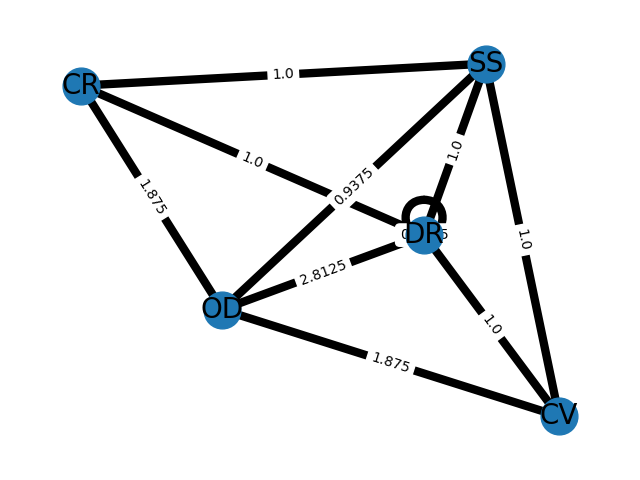

In [19]:
wW = 1- .25**2 #window-wall area
dW = 1 - .25*.75 #door-wall area
roomList = [
    ("CR", {}), 
    ("SS", {}), 
    ("DR", {}), 
    ("CV", {}), 
    ("OD", {})
    ]

connectivityMatrix = np.array([
    [0, 1, 1, 0, 2*wW],
    [1, 0, 1 ,1, wW],
    [1, 1, dW, 1, 3*wW],
    [0, 1, 1, 0, 2*wW],
])

bG = abs.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

bG.updateAllEdges({"wall_kwargs" :wall_kwargs})
bG.updateAllNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs
    })


# show graph edge data
display(bG.G.edges.data())
display(bG.G.nodes.data())

In [9]:
type(bG)

abstractions.buildingGraph